# Generative Adversarial Imputation Networks

## [Reference](https://github.com/jsyoon0823/GAIN)

### 실제로 이 것을 적용하고 싶을 때 어떻게 해야 할지

> 일단 전부 다 가진 데이터를 활용하여  Train / Test 로 나눠서 G를 훈련시키고 

> 그 이후에 Test Mse Loss가 줄어들었을 때의 모델을 활용하여서 G를 만든다.

> 우리가 G를 이용해서 샘플을 만들 떄 필요한 것은 X,Z,M 3가지다.

    * X : Missinge Value가 있는 것
    * Z : 임의의 Noise
    * M : value 가 있으면 1 나머지는 0 이런식으로 되어있어서, 0 인 부분에 Z 를 넣는다.
    * ==> 학습 된 G ==> Missing 이 처리된 값이 나온다.
    * 추가로 Spectral Normalization 적용하니 더욱 더 Loss가 작게 시작하는 것 같다.
    * Scaling 을 해줘야 더 잘 된다. 후에 역변환으로 복원하는 방식
    * 이때 나는 Round를 쓸 생각을 하지만 다음에는 Onehot으로 만든 뒤 softmax? 해야 할 것 같음...

In [1]:
import tensorflow as tf
import numpy as np , pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm
import pprint
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
pp = pprint.PrettyPrinter(width=30, indent=10)

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")
    
    
device = ['/cpu:0' , '/cpu:0'] 

No GPU found


In [3]:
data = pd.read_csv("./../../data/credit44_sc.csv")

In [4]:
fac_var = []
num_var = []
for i in list(data) : 
    if data[i].nunique() < 15 : 
        print("factor variable : {}, count : {} ".format(i, data[i].nunique()))
        fac_var.append(i)
        if data[i].nunique() == 2 :
            print("binary" , i)
    else : 
        print("연속형 variable : {} , count : {} ".format(i, data[i].nunique()))
        num_var.append(i)
        
data = data.loc[:,fac_var + num_var]

col = list(data)

연속형 variable : SCORE_ORG , count : 395 
연속형 variable : SCORE_NK0200_000 , count : 445 
연속형 variable : SCORE_RK0400_700 , count : 294 
factor variable : CNT_CONTACT_POS, count : 8 
factor variable : CNT_ENG, count : 7 
factor variable : DAYS_CONTACT_POS, count : 11 
factor variable : DAYS_CALL_PAYMENT, count : 11 
factor variable : EWS_C_N_P27000100, count : 14 
연속형 variable : EWS_A_K_D1M232000_OPR , count : 2384 
factor variable : EWS_C_N_P42000200, count : 14 
연속형 variable : EWS_C_N_P32003000 , count : 31 
연속형 variable : AGE , count : 54 
연속형 variable : CNT_Contact , count : 29 
연속형 variable : EWS_A_K_D1M23200C_OPR , count : 2384 
연속형 variable : EWS_C_K_D10310000_OPR , count : 52 
연속형 variable : EWS_A_K_D90232200_OPR , count : 2490 
연속형 variable : D_N_CA0000603 , count : 4894 
연속형 variable : EWS_C_N_P32002600 , count : 22 
연속형 variable : EWS_D_N_P43004000 , count : 399 
factor variable : C_N_PS0001777, count : 11 
factor variable : A_K_D10220000_OPR, count : 9 
연속형 variable : SCORE_RK

In [5]:
def spectral_norm(w, iteration=1 , name = None):
    w_shape = w.shape.as_list()
    w = tf.reshape(w, [-1, w_shape[-1]])
    
    u = tf.get_variable(name , [1, w_shape[-1]], initializer=tf.random_normal_initializer(), trainable=False)

    u_hat = u
    v_hat = None
    for i in range(iteration):
       
        """
       power iteration
       Usually iteration = 1 will be enough
       """
        
        v_ = tf.matmul(u_hat, tf.transpose(w))
        v_hat = tf.nn.l2_normalize(v_)

        u_ = tf.matmul(v_hat, w)
        u_hat = tf.nn.l2_normalize(u_)

    u_hat = tf.stop_gradient(u_hat)
    v_hat = tf.stop_gradient(v_hat)

    sigma = tf.matmul(tf.matmul(v_hat, w), tf.transpose(u_hat))

    with tf.control_dependencies([u.assign(u_hat)]):
        w_norm = w / sigma
        w_norm = tf.reshape(w_norm, w_shape)

    return w_norm 

In [6]:
_, Dim = np.shape(data)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [7]:
trainX, testX  = train_test_split(data , test_size = 0.33, random_state = 42)

In [8]:
mb_size = 128
p_miss = 0.5
p_hint = 0.9
alpha = 10


In [9]:
def sample_M(m, n, p):
    A = np.random.uniform(0., 1., size = [m, n])
    ## p 기준으로 True False 
    B = A > p
    ## 맞으면 1 아니면 0 
    C = 1.*B
    """해당하는 배치사이즈만큼의 mask vector 와 hint vector 생성"""
    return C

In [10]:
Train_No , Test_No = len(trainX) , len(testX)

In [11]:
trainM = sample_M(Train_No, Dim, p_miss)
testM = sample_M(Test_No, Dim, p_miss)

In [12]:
pp.pprint(trainM[0 , :])

array([1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1.])


In [13]:
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6], [7, 8]])
np.concatenate((a, b), axis=1)

array([[1, 2, 5, 6],
       [3, 4, 7, 8]])

In [14]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape = size, stddev = xavier_stddev)

In [15]:
def G( x,z,m , reuse = tf.AUTO_REUSE) : 
    with tf.device(device[1]) :
        with tf.variable_scope("Generator" , reuse = reuse) as scope: 
            G_W1 = tf.get_variable("GW1",[Dim*2, h_dim], dtype=tf.float32 , initializer=tf.contrib.layers.xavier_initializer())
            G_b1 = tf.get_variable("GB1",[h_dim],dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            G_W2 = tf.get_variable("GW2" ,[h_dim, h_dim], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
            G_b2 = tf.get_variable("GB2",[h_dim], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            G_W3 = tf.get_variable("GW3" ,[h_dim, h_dim], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
            G_b3 = tf.get_variable("GB3",[h_dim], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            G_W4 = tf.get_variable("GW4" ,[h_dim, Dim], dtype=tf.float32)
            G_b4 = tf.get_variable("GB4",[Dim], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            
            
            inp = m * x + (1-m) * z  # Fill in random noise on the missing values
            inputs = tf.concat(axis = 1, values = [inp,m])  # Mask + Data Concatenate
            G_h1 = tf.matmul(inputs, G_W1 ) + G_b1
            G_h1 = tf.contrib.layers.batch_norm(G_h1)
            #G_h1 = tf.layers.dropout(G_h1)
            G_h1 = tf.nn.leaky_relu(G_h1)
            G_h2 = tf.matmul(G_h1, G_W2 ) + G_b2
            G_h2 = tf.contrib.layers.batch_norm(G_h2)
            #G_h2 = tf.layers.dropout(G_h2)
            G_h2 = tf.nn.leaky_relu(G_h2)
            G_h3 = tf.matmul(G_h2, G_W3) + G_b3
            #G_h3 = tf.layers.dropout(G_h3)
            G_h3 = tf.contrib.layers.batch_norm(G_h3)
            G_h3 = tf.nn.leaky_relu(G_h3)
            
            G_log_prob = tf.matmul(G_h3, G_W4) # + G_b2 Bias는 일단 제외 
            G_log_prob = tf.nn.tanh(G_log_prob)
            
        return G_log_prob 

    
    
def D(x, m, g, h,reuse=tf.AUTO_REUSE ):
    with tf.device(device[0]) :
        with tf.variable_scope( "Discriminator" ,reuse=reuse  ) as scope :
            inp = m * x + (1-m) * g  
            inputs = tf.concat(axis = 1, values = [inp,h])  # Hint + Data Concatenate
            D_W1 = tf.get_variable("DW1",[Dim*2, h_dim], dtype=tf.float32)
            D_b1 = tf.get_variable("DB1", [h_dim], dtype=tf.float32 , initializer=tf.constant_initializer(0.0))
            D_W2 = tf.get_variable("DW2",[h_dim, h_dim], dtype=tf.float32)
            D_b2 = tf.get_variable("DB2",[h_dim], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            D_W3 = tf.get_variable("DW3",[h_dim, h_dim], dtype=tf.float32)
            D_b3 = tf.get_variable("DB3",[h_dim], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            D_W4 = tf.get_variable("DW4",[h_dim, Dim], dtype=tf.float32)
            D_b4 = tf.get_variable("DB4",[Dim], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            
            
            D_h1 = tf.nn.leaky_relu(tf.matmul(inputs, spectral_norm(D_W1 , name ="sn1")) + D_b1)
            D_h2 = tf.nn.leaky_relu(tf.matmul(D_h1, spectral_norm(D_W2 , name ="sn2")) + D_b2)
            D_h3 = tf.nn.leaky_relu(tf.matmul(D_h2, spectral_norm(D_W3 , name ="sn3")) + D_b3)
            out = tf.matmul(D_h3 , D_W4) # + D_b4
        return out
    
def sample_Z(m, n):
    return np.random.uniform(0., 1., size = [m, n])        

# permutation 말 그래도 데이터를 뒤섞을 수 있다.
# m개중 앞에 n개만 가져오겠다.

def sample_idx(m, n):
    A = np.random.permutation(m)
    idx = A[:n]
    return idx

In [16]:
X = tf.placeholder(tf.float32, shape = [None, Dim])
# 1.2. Mask Vector 
M = tf.placeholder(tf.float32, shape = [None, Dim])
# 1.3. Hint vector
H = tf.placeholder(tf.float32, shape = [None, Dim])
# 1.4. Random Noise Vector
Z = tf.placeholder(tf.float32, shape = [None, Dim])

h_dim = 96

In [17]:
G_sample = G(X,Z,M)
D_prob = D(X, M, G_sample, H)

#%% Loss
D_loss1 = -tf.reduce_mean(M * tf.log(D_prob + 1e-8) + (1-M) * tf.log(1. - D_prob + 1e-8)) * 2
G_loss1 = -tf.reduce_mean((1-M) * tf.log(D_prob + 1e-8)) / tf.reduce_mean(1-M)
MSE_train_loss = tf.reduce_mean((M * X - M * G_sample)**2) / tf.reduce_mean(M)

D_loss = D_loss1
G_loss = G_loss1  + alpha * MSE_train_loss 

#%% MSE Performance metric
MSE_test_loss = tf.reduce_mean(((1-M) * X - (1-M)*G_sample)**2) / tf.reduce_mean(1-M)

t_vars = tf.trainable_variables()
print(t_vars)
d_vars = [var for var in t_vars if 'Discriminator' in var.name]
g_vars = [var for var in t_vars if 'Generator' in var.name]



with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    G_solver = tf.train.AdamOptimizer(1e-4 , beta1=0.5).minimize(G_loss, var_list=g_vars)
    D_solver = tf.train.AdamOptimizer(1e-4, beta1=0.5).minimize(D_loss, var_list=d_vars)

# Sessions
sess = tf.Session()
sess.run(tf.global_variables_initializer())


[<tf.Variable 'Generator/GW1:0' shape=(90, 96) dtype=float32_ref>, <tf.Variable 'Generator/GB1:0' shape=(96,) dtype=float32_ref>, <tf.Variable 'Generator/GW2:0' shape=(96, 96) dtype=float32_ref>, <tf.Variable 'Generator/GB2:0' shape=(96,) dtype=float32_ref>, <tf.Variable 'Generator/GW3:0' shape=(96, 96) dtype=float32_ref>, <tf.Variable 'Generator/GB3:0' shape=(96,) dtype=float32_ref>, <tf.Variable 'Generator/GW4:0' shape=(96, 45) dtype=float32_ref>, <tf.Variable 'Generator/GB4:0' shape=(45,) dtype=float32_ref>, <tf.Variable 'Generator/BatchNorm/beta:0' shape=(96,) dtype=float32_ref>, <tf.Variable 'Generator/BatchNorm_1/beta:0' shape=(96,) dtype=float32_ref>, <tf.Variable 'Generator/BatchNorm_2/beta:0' shape=(96,) dtype=float32_ref>, <tf.Variable 'Discriminator/DW1:0' shape=(90, 96) dtype=float32_ref>, <tf.Variable 'Discriminator/DB1:0' shape=(96,) dtype=float32_ref>, <tf.Variable 'Discriminator/DW2:0' shape=(96, 96) dtype=float32_ref>, <tf.Variable 'Discriminator/DB2:0' shape=(96,) dty

In [18]:
print(G_sample)

Tensor("Generator/Tanh:0", shape=(?, 45), dtype=float32, device=/device:CPU:0)


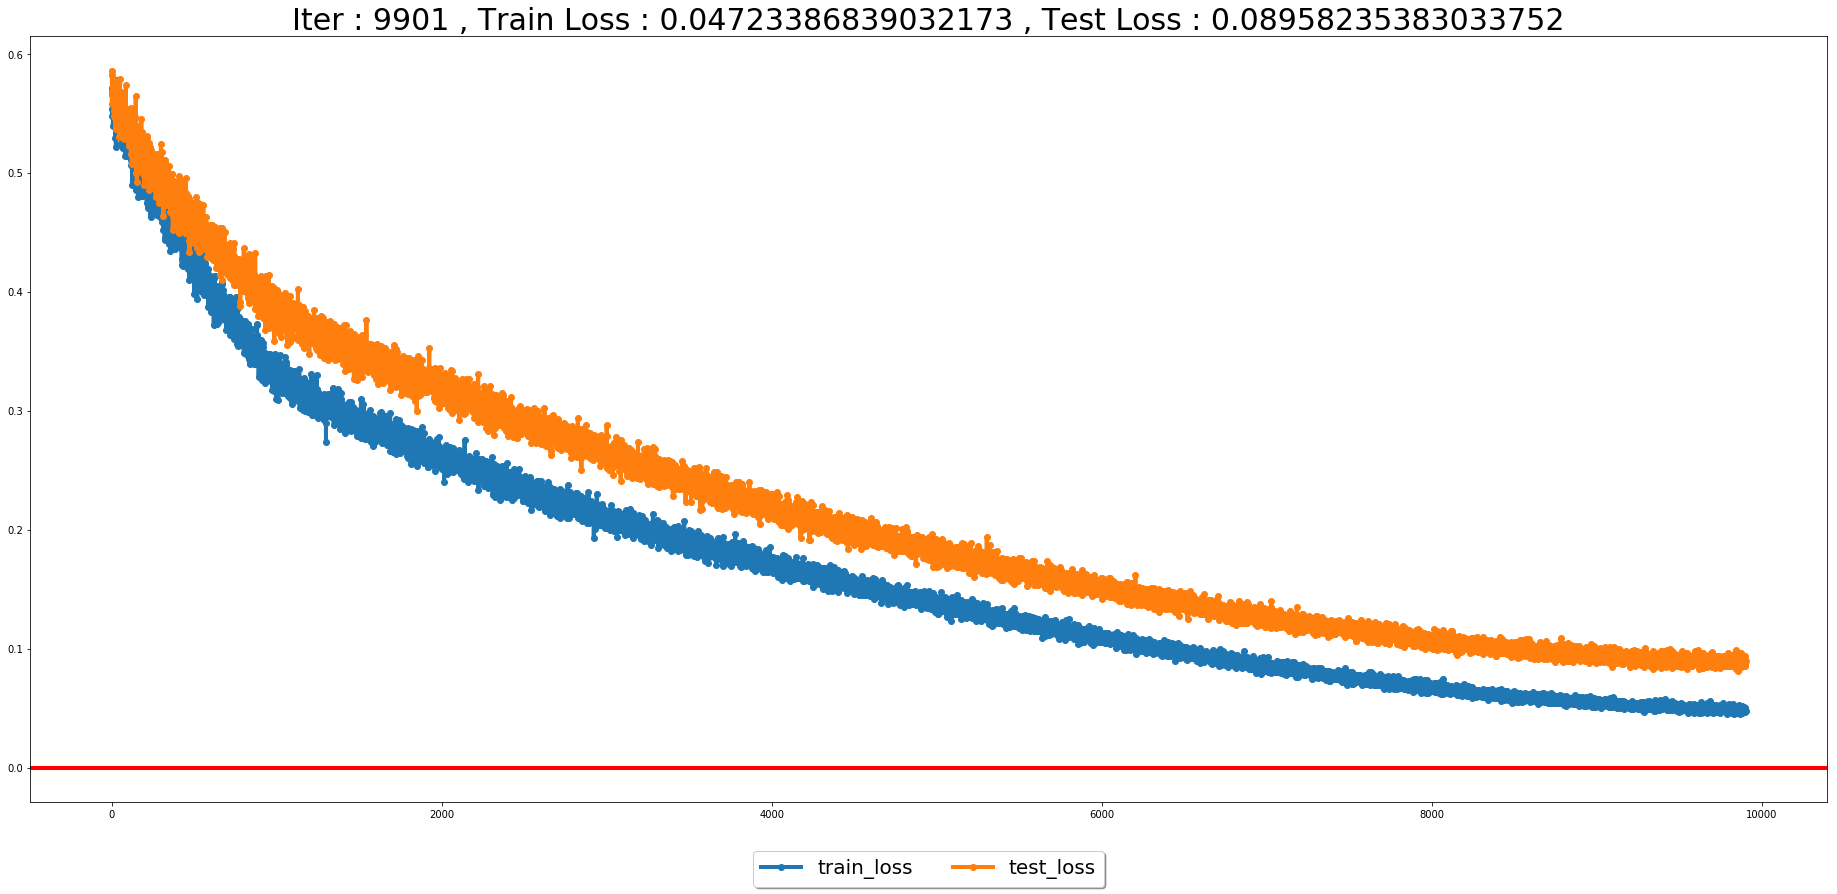

In [19]:
i = 1
iteration = 0
output = pd.DataFrame({"iter" : [iteration] , "train_loss" : [0] , "test_loss" : [0] })
for i in tqdm(range(10000)):    
    
    #%% Inputs
    """
    55000 에서 , 앞에서 mb_size 만큼 뽑기 : mb_idx
    Z_mb  : mb_size , Dim 만큼의 uniform 뽑기 
    """
    mb_idx = sample_idx(Train_No, mb_size)
    X_mb = trainX[mb_idx,:]  
    Z_mb = sample_Z(mb_size, Dim) 
    """
    위에서 만든 RANDOM 으로 Uniform 으로 생성된 miss 율에 따른 사이에 있으면 1 아니면 0 
    """
    M_mb = trainM[mb_idx,:]  
    """
    위에서 만든 RANDOM 으로 Uniform 으로 생성된 miss 율에 따른 사이에 있으면 1 아니면 0 
    """
    H_mb1 = sample_M(mb_size, Dim, 1-p_hint)
    H_mb = M_mb * H_mb1
    
    New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce
    
    _, D_loss_curr = sess.run([D_solver, D_loss1], feed_dict = {X: X_mb, M: M_mb, Z: New_X_mb, H: H_mb})
    _, G_loss_curr, MSE_train_loss_curr, MSE_test_loss_curr = sess.run([G_solver, G_loss1, MSE_train_loss, MSE_test_loss],
                                                                       feed_dict = {X: X_mb, M: M_mb, Z: New_X_mb, H: H_mb})
    
    iteration +=1 
    output1 = pd.DataFrame({"iter" : [iteration] , "train_loss" : [MSE_train_loss_curr] , "test_loss" : [MSE_test_loss_curr] })
    output  = output.append(output1)
    
   
    if i % 100 == 0 :
        clear_output(wait= True)
        fig , ax = plt.subplots(figsize = (26,13))
        fig.subplots_adjust(top = 0.95 , left = 0.03 , bottom = 0.04 , right = 0.99)
        output = output[output.iter>0]
        ax.plot(output.iter , output.train_loss , label ="train_loss" , linestyle ="-" , marker ="." , linewidth = 4, markersize = 12)
        ax.plot(output.iter , output.test_loss , label ="test_loss" , linestyle ="-" , marker ="." , linewidth = 4, markersize = 12)
        ax.set_title("Iter : {} , Train Loss : {} , Test Loss : {}".format( iteration ,  MSE_train_loss_curr, MSE_test_loss_curr ), fontsize= 30)
        ax.axhline(0.0, linewidth=4, color='r')
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4 , fontsize= 20)    
        plt.show()
#     print('Iter: {}'.format(i))
#     print('Train_loss: {:.4f}'.format(MSE_train_loss_curr))
#     print('Test_loss: {:.4f}'.format(MSE_test_loss_curr))
#     print()
